In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
# cd /content/drive/My\ Drive/ClassificationImages/Shape/dogs_vs_cats_pytorch/

In [1]:
# !pip install torchattacks

from lib import *
from config import *
from model import build_model, build_model_mnist
from utils import * 
import torchattacks
from torchattacks import PGD, FGSM

classes = ['dog', 'cat']

net_type = 'rgb'

eps_t = 16

save_path = f'dogs_cats_{net_type}.pth'
save_path_robust = f'dogs_cats_{net_type}_{eps_t}_robust.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train a model first

In [2]:
net, dataloader_dict, criterior, optimizer = build_model(net_type=net_type)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [ ]:
NUM_EPOCHS = 30
train_model(net, dataloader_dict, criterior, optimizer, NUM_EPOCHS, save_path)


In [ ]:
net_type
save_path

'dogs_cats_rgb.pth'

# Test the model on clean and attacks

In [3]:
net, dataloader_dict, criterior, optimizer = build_model(net_type=net_type)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [4]:
load_model(net, save_path)
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [7]:
def test_model_clean(net, dataloader_dict):
    correct = 0
    total = 0

    # device GPU or CPU?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: {}".format(device))

    # move network to train on device 
    net.to(device)
    net.eval()
    
    
    for images, labels in dataloader_dict['val']:    
        # images = (images-images.min()) / (images.max()-images.min())
        images, labels = images.to(device), labels.to(device)         
        
        
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
    #     correct += (predicted == labels.cuda()).sum()
        correct += (predicted == labels).sum()

    acc = float(correct) / total
        
    return acc, images    


In [6]:
net_type

'rgb'

In [7]:
def test_model_attack(net, dataloader_dict, epsilons, net_type):
    # device GPU or CPU?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: {}".format(device))

    # move network to train on device 
    net.to(device)
    
    net.eval()
    accuracies = []; examples = []

    for eps in epsilons:
        correct = 0; total = 0;       
        print(eps)
        fgsm_attack = FGSM(net, eps=eps)

        # import pdb; pdb.set_trace()
        for images, labels in dataloader_dict['val']:
            images, labels = images.to(device), labels.to(device)         
            # images = (images-images.min()) / (images.max()-images.min())                
            images = fgsm_attack(images, labels)#.cuda()

            
            if net_type.lower() in ['rgb', 'edge']:
                outputs = net(images)
            else: # rgb + edge
                # with newly computed edge map  
                # images_edge = images.detach().clone()
                images_edge = detect_edge_batch(images)
                outputs = net(images_edge)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()

        acc = float(correct) / total
        accuracies.append(acc)

    return accuracies, images    


In [7]:
acc, images = test_model_clean(net, dataloader_dict)
print('Accuracy of original model on clean images: %f ' % acc)

device: cpu


/Users/ali/Documents/Research/dogs_vs_cats_pytorch/model.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Accuracy of original model on clean images: 0.733000 


In [8]:
epsilons = [eps_t/256]

acc_attack, images = test_model_attack(net, dataloader_dict, epsilons, net_type)
print('Accuracy of clean model on adversarial images: %f %%' % acc_attack[0])

device: cpu
0.0625


/Users/ali/Documents/Research/dogs_vs_cats_pytorch/model.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Accuracy of clean model on adversarial images: 0.079000 %


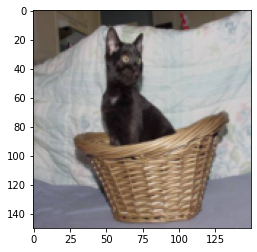

In [8]:
plt.imshow(images[10,:3].permute(1,2,0).cpu()); plt.show()
# plt.imshow(images[10,0].cpu()); plt.show()

In [ ]:
# n_s = 1
# imshow(torchvision.utils.make_grid(images[:n_s,:3], nrow=n_s, normalize=True), '                  '.join([classes[i] for i in predicted[:n_s]]))
# imshow(torchvision.utils.make_grid(images[:n_s], nrow=n_s, normalize=True),'')

# imshow(torchvision.utils.make_grid(images_edge[:n_s,:3], nrow=n_s, normalize=True), '                  '.join([classes[i] for i in predicted_edge[:n_s]]))
# imshow(torchvision.utils.make_grid(images_edge[:n_s], nrow=n_s, normalize=True),'')

In [ ]:
# plt.imshow(images[0,:3].permute(1,2,0)); 
# plt.title(predicted[0]);plt.show()

# plt.imshow(images[0,3]); 


In [ ]:
# # Train model
# def train_robust_model(net, dataloader_dict, criterior, optimizer, num_epochs, save_path, eps=8/256, net_type='rgb'):

#     # device GPU or CPU?
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print("device: {}".format(device))

#     # move network to train on device 
#     net.to(device)

#     # # make a copy of the net first
#     # net_copy, _, _, _ = build_model(net_type=net_type)   
#     # net_copy.to(device) 
#     # net_copy.load_state_dict(copy.deepcopy(net.state_dict()))
#     # # net_copy = torch.clone(net) #copy.deepcopy(net)    
#     # fgsm_attack = FGSM(net_copy, eps=eps)    


#     net_copy = copy.deepcopy(net)
#     fgsm_attack = FGSM(net_copy, eps=eps)    


#     # boost network speed on gpu
#     torch.backends.cudnn.benchmark = True

#     for epoch in range(num_epochs):
#         print("Epoch {}/{}".format(epoch+1, num_epochs))

#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 net.train()
#             else:
#                 net.eval()

#             epoch_loss = 0.0
#             epoch_corrects = 0

#             if (epoch == 0) and (phase == 'train'):
#                 continue

#             for inputs, labels in tqdm(dataloader_dict[phase]):
#                 # move inputs, labels to GPU/CPU device
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)
#                 inputs = (inputs-inputs.min()) / (inputs.max()-inputs.min())    

#                 # borji; perform the attack with probability .5
#                 # if torch.rand(1).item() < 1.5:
#                 # import pdb; pdb.set_trace()
# #                     inputs = inputs.clone(requires_grad = True)
#                 # inputs = (inputs-inputs.min()) / (inputs.max()-inputs.min())    
                
#                 inputs = fgsm_attack(inputs, labels)#.cuda()
#                 inputs = (inputs-inputs.min()) / (inputs.max()-inputs.min())                    
                
                
#                 # with newly computed edge map  
#                 if net_type.lower() not in ['rgb', 'edge']: # for 
#                      inputs = detect_edge_batch(inputs)
                
                
#                 # set gradients of optimizer to zero
#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = net(inputs)
#                     labels = labels
#                     loss = criterior(outputs, labels)
#                     _, preds = torch.max(outputs, axis=1)

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                     epoch_loss += loss.item() * inputs.shape[0]
#                     epoch_corrects += torch.sum(preds==labels.data)


#             epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
#             epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

#             print("{} Loss: {:.4f}, Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))

# #     import pdb; pdb.set_trace()

#     torch.save(net.state_dict(), save_path)
# #     return net

# Train model
def train_robust_model(net, dataloader_dict, criterior, optimizer, num_epochs, save_path, eps=8/256, net_type='rgb'):

    # device GPU or CPU?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: {}".format(device))

    # move network to train on device 
    net.to(device)

    # make a copy of the net first
    # net_copy = copy.deepcopy(net)
    # fgsm_attack = FGSM(net_copy, eps=eps)    

    fgsm_attack = FGSM(net, eps=eps)    


    # boost network speed on gpu
    torch.backends.cudnn.benchmark = True

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0
            epoch_corrects = 0
            epoch_corrects_adv = 0

            if (epoch == 0) and (phase == 'train'):
                continue

            for inputs, labels in tqdm(dataloader_dict[phase]):
                # move inputs, labels to GPU/CPU device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # borji; perform the attack with probability .5
#                 if torch.rand(1).item() < .5:
#                     import pdb; pdb.set_trace()
#                     inputs = inputs.clone(requires_grad = True)
#                 inputs = (inputs-inputs.min()) / (inputs.max()-inputs.min())    
                
                inputs_adv = fgsm_attack(inputs, labels)#.cuda()
                
                # set gradients of optimizer to zero
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    labels = labels
                    loss = criterior(outputs, labels)
                    _, preds = torch.max(outputs, axis=1)


                    # with newly computed edge map  
                    if net_type.lower() not in ['rgb', 'edge']: # for 
                        # import pdb; pdb.set_trace()
                        inputs_adv = detect_edge_batch(inputs_adv)

                    outputs_adv = net(inputs_adv)
                    labels = labels
                    loss_adv = criterior(outputs_adv, labels)
                    _, preds_adv = torch.max(outputs_adv, axis=1)

                    alpha = .1
                    loss = alpha*loss + (1-alpha)*loss_adv
                    


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.shape[0]
                    # epoch_corrects += torch.sum(preds==labels.data)
                    epoch_corrects += torch.sum(preds==labels.data)
                    epoch_corrects_adv += torch.sum(preds_adv==labels.data)



            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_accuracy = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            epoch_accuracy_adv = epoch_corrects_adv.double() / len(dataloader_dict[phase].dataset)


            print("{} Loss: {:.4f}, Acc: {:.4f}, Acc_adv: {:.4f}".format(phase, epoch_loss, epoch_accuracy, epoch_accuracy_adv))

#     import pdb; pdb.set_trace()

    torch.save(net.state_dict(), save_path)
#     return net

# Now perform adversarial training

In [21]:
net_robust, dataloader_dict, criterior, optimizer = build_model(net_type)
net_robust.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [22]:
save_path_robust

'dogs_cats_rgb_16_robust.pth'

In [ ]:
load_model(net_robust, save_path) # load orig model first

In [ ]:
NUM_EPOCHS = 30
train_robust_model(net_robust, dataloader_dict, criterior, optimizer, NUM_EPOCHS, save_path_robust, eps=eps_t/256, net_type=net_type)

# Test the robust model on clean and attacks

In [57]:
net_robust, dataloader_dict, criterior, optimizer = build_model(net_type)

Net(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [58]:
load_model(net_robust, save_path_robust) # load orig model first
net_robust.to(device)

Net(
  (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [62]:
save_path_robust

'dogs_cats_rgbedge_robust.pth'

In [25]:
acc, images = test_model_clean(net_robust, dataloader_dict)
print('Accuracy of robust model on clean images: %f %%' % acc)

device: cuda:0


/content/drive/My Drive/ClassificationImages/Shape/dogs_vs_cats_pytorch/model.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Accuracy of robust model on clean images: 0.779000 %


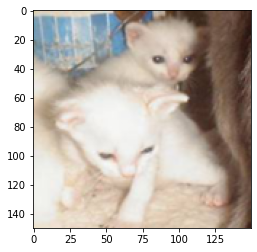

In [26]:
plt.imshow(images[19,:3].permute(1,2,0).cpu()); plt.show()

In [24]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
epsilons = [8/256]

acc_attack, images = test_model_attack(net_robust, dataloader_dict, epsilons, net_type)
print('Accuracy of robust model on adversarial images: %f %%' % acc_attack[0])

device: cuda:0
0.03125


/content/drive/My Drive/ClassificationImages/Shape/dogs_vs_cats_pytorch/model.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))


Accuracy of robust model on adversarial images: 0.066000 %


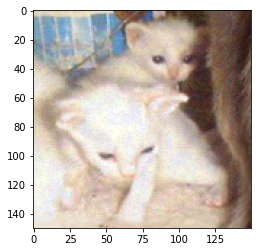

In [72]:
plt.imshow(images[19,:3].permute(1,2,0).cpu()); plt.show()

In [56]:
plt.imshow(images[8,3].cpu()); plt.show()

IndexError: ignored

In [ ]:
plt.imshow(images_edge[8,:3].permute(1,2,0)); plt.show()

In [ ]:
plt.imshow(images_edge[8,3]); plt.show()

# MNIST Zone

In [1]:
# !pip install torchattacks

from lib import *
from config import *
from model import build_model, build_model_mnist
from utils import * 
import torchattacks
from torchattacks import PGD, FGSM

classes = ['dog', 'cat']

net_type = 'grayedge'

eps_t = 8

save_path = f'mnist_{net_type}.pth'
save_path_robust = f'mnist_{net_type}_{eps_t}_robust.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
net, dataloader_dict, criterior, optimizer = build_model_mnist(net_type=net_type)

MNIST_Net(
  (conv1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [11]:
# next(iter(dataloader_dict['train']))

In [17]:
NUM_EPOCHS = 3
train_model(net, dataloader_dict, criterior, optimizer, NUM_EPOCHS, save_path)


  0%|          | 2/600 [00:00<00:41, 14.52it/s]

device: cpu
Epoch 1/3
Epoch 2/3


  0%|          | 2/600 [00:00<00:40, 14.90it/s]

train Loss: 1.6060, Acc: 0.4611
Epoch 3/3


100%|██████████| 600/600 [00:39<00:00, 15.30it/s]

train Loss: 0.7783, Acc: 0.7562


In [5]:
net

MNIST_Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [6]:
dataloader_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x109330110>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x109304f90>}

In [18]:
acc, images = test_model_clean(net, dataloader_dict)
print('Accuracy of original model on clean images: %f ' % acc)

device: cpu
Accuracy of original model on clean images: 0.898600 


In [19]:
net_robust, dataloader_dict, criterior, optimizer = build_model_mnist(net_type=net_type)

MNIST_Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [20]:
NUM_EPOCHS = 3
save_path_robust = 'xx.pth'
train_robust_model(net_robust, dataloader_dict, criterior, optimizer, NUM_EPOCHS, save_path_robust, eps=eps_t/256, net_type=net_type)

device: cpu
Epoch 1/3
Epoch 2/3
train Loss: 1.6125, Acc: 0.4802, Acc_adv: 0.4332
Epoch 3/3


KeyboardInterrupt: 

In [3]:
test_model_attack(net, dataloader_dict, [.1], net_type, redetect_edge=True)

device: cpu
0.1


KeyboardInterrupt: 

# Fashion MNIST

In [9]:
# !pip install torchattacks

from lib import *
from config import *
from model import build_model, build_model_mnist, build_model_fashion_mnist
from utils import * 
import torchattacks
from torchattacks import PGD, FGSM

classes = ['dog', 'cat']

net_type = 'edge'

eps_t = 8

save_path = f'mnist_{net_type}.pth'
save_path_robust = f'mnist_{net_type}_{eps_t}_robust.pth'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
net, dataloader_dict, criterior, optimizer = build_model_fashion_mnist(net_type=net_type)

MNIST_Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [22]:
a, b = next(iter(dataloader_dict['train']))

In [12]:
a[0].shape

torch.Size([1, 28, 28])

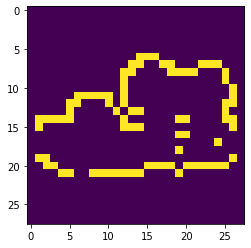

In [25]:
plt.imshow(a[10,0]); plt.show()